# Análisis preliminar

A continuación realizamos un análisis preliminar del dataset de precios de pañales obtenido. Dividiremos el análisis en las siguientes fases:

- Descripción de atributos
- Consumo de Pañales VS Canásta Básica (Indec)
- Presupuesto destinado a pañales en los primeros *n* meses de vida del bebe

In [666]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
def prepare_df():
    df = pd.read_csv('diapers.csv')
    # filter items that are wrongly calculated
    return df[df['unit_price'] < 200]

df = prepare_df()
df

,price,website,brand,size,target_kg_min,target_kg_max,units,unit_price
0,999.99,www.perfumeriasmiriam.com.ar,babysec,g,8.5,12.0,36,27.78
1,999.99,www.perfumeriasmiriam.com.ar,babysec,m,5.0,9.5,44,22.73
2,999.99,www.perfumeriasmiriam.com.ar,babysec,xxg,13.0,20.0,26,38.46
3,999.99,www.perfumeriasmiriam.com.ar,babysec,xg,11.0,15.0,28,35.71
4,1000.00,www.perfumeriasmiriam.com.ar,pampers,p,5.0,7.5,36,27.78
...,...,...,...,...,...,...,...,...
5345,2230.53,www.anaperfumeriaonline.com.ar,pampers,g,9.0,12.0,68,32.80
5346,4610.42,www.anaperfumeriaonline.com.ar,pampers,xxg,14.0,20.0,88,52.39
5347,4610.42,www.anaperfumeriaonline.com.ar,pampers,xg,12.0,15.0,96,48.03
5348,4610.42,www.anaperfumeriaonline.com.ar,pampers,g,9.0,12.0,110,41.91


## Descripción de atributos

Observamos los atributos recabados:

- **price**. Precio por paquete (antes precio).
- **website**. Identificar el vendedor.
- **brand**. Identificar la marca. Extraer atributo de description.
- **size**. Talle del pañal. Extraer atributo de description.
- **target_kg(\_min|\_max)**. Tamaño mínimo y máximo en KGs soportado. Clasificar atributo en base a tabla.
- **units**. Unidades por paquete. Extraer atributo de description.
- **unit_price**. Precio unitario. Calcular a partir de price/units.

In [667]:
df.head()

,price,website,brand,size,target_kg_min,target_kg_max,units,unit_price
0,999.99,www.perfumeriasmiriam.com.ar,babysec,g,8.5,12.0,36,27.78
1,999.99,www.perfumeriasmiriam.com.ar,babysec,m,5.0,9.5,44,22.73
2,999.99,www.perfumeriasmiriam.com.ar,babysec,xxg,13.0,20.0,26,38.46
3,999.99,www.perfumeriasmiriam.com.ar,babysec,xg,11.0,15.0,28,35.71
4,1000.00,www.perfumeriasmiriam.com.ar,pampers,p,5.0,7.5,36,27.78


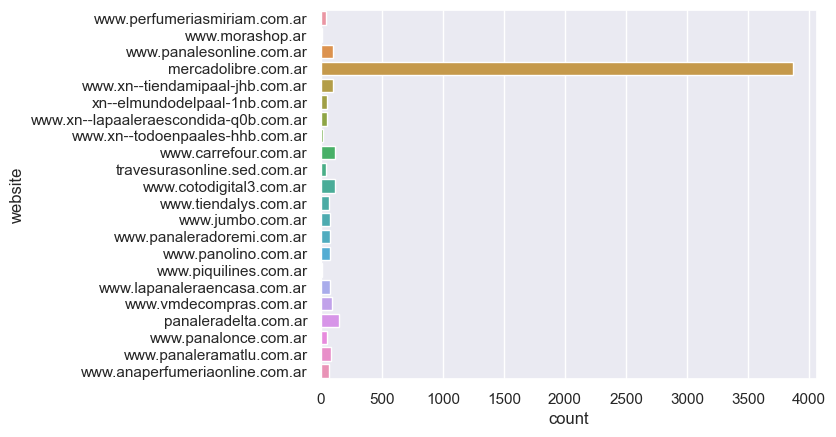

In [668]:
def add_values(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

ax = sns.countplot(y="website", data=df, orient="h")

### Distribución items websites (sin Mercadolibre)

Observamos la distribución de los websites quitando Mercadolibre

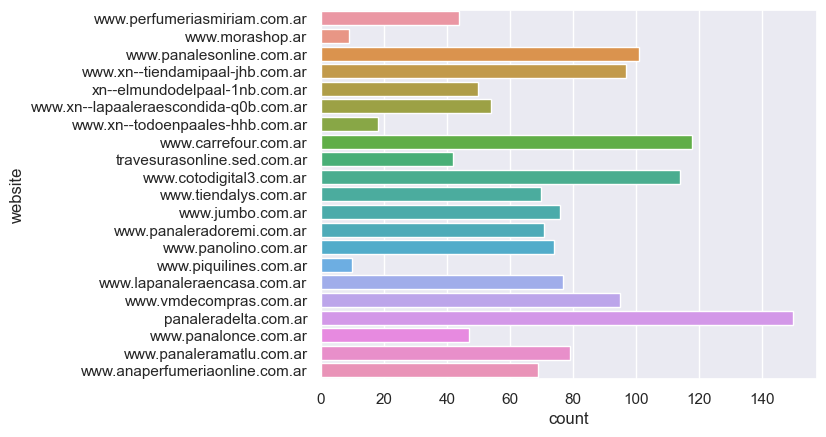

In [669]:
e = df[df['website'] != 'mercadolibre.com.ar']
ax = sns.countplot(y="website", data=e, orient="h")

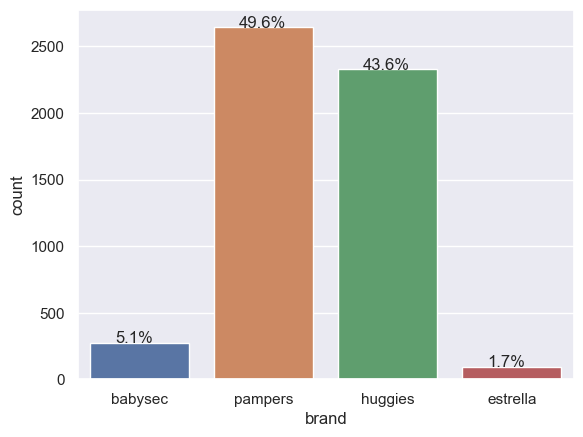

In [670]:
ax = sns.countplot(x="brand", data=df)
add_values(ax, df)

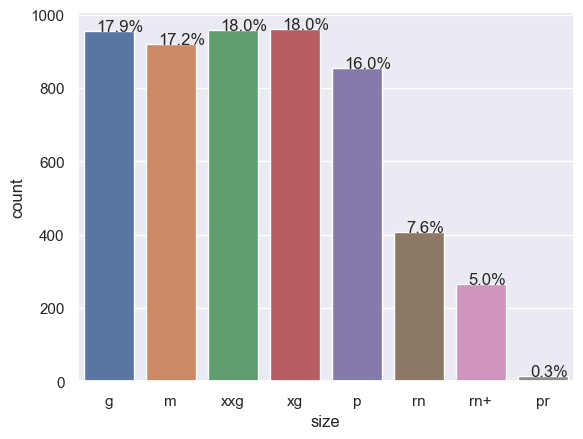

In [671]:
ax = sns.countplot(x="size", data=df)
add_values(ax, df)

Observamos que a mayor talle mayor precio unitario

<AxesSubplot: xlabel='brand', ylabel='unit_price'>

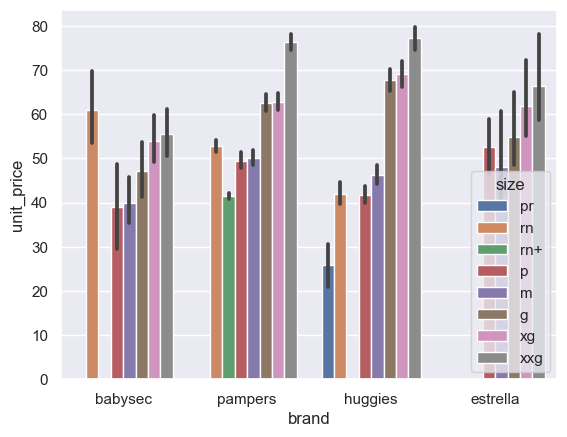

In [672]:
order_sizes = ["pr", "rn", "rn+", "p", "m", "g", "xg", "xxg"]
sns.barplot(data=df, x="brand", y="unit_price", hue="size", hue_order=order_sizes)

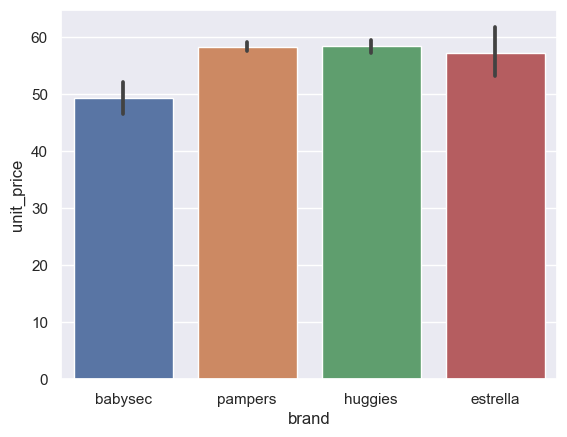

In [673]:
ax = sns.barplot(data=df, x="brand", y="unit_price")

### Distribuciones utilizadas

Utilizando una distribución normal con 1 unidad desvio standard. Utilizamos las siguientes configuraciones:

- Recién nacido hasta 2 meses - 7 pañales al dia
- De 3 a 8 meses - 6 pañales al dia
- De 9 a 24 meses - 5 pañales al dia

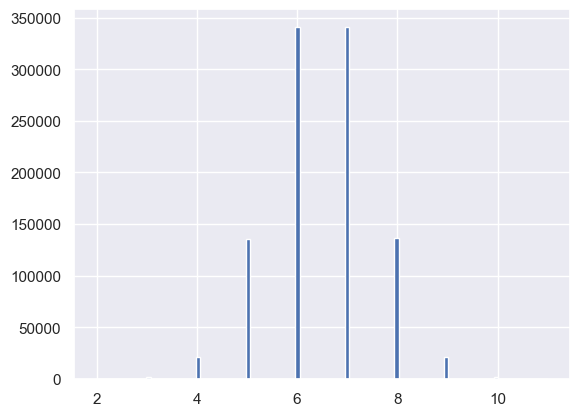

In [674]:
import random
_rand = lambda x: int(random.normalvariate(x, 1))


def _get_random_daily_usage(month):
    if month < 3:
        return _rand(7)
    if month < 9:
        return _rand(6)
    return _rand(5)

plt.hist([_get_random_daily_usage(1) for _ in range(1_000_000)], bins=100)
plt.show()

## Consumo de pañales VS canasta básica

A continuación comparamos el consumo de pañales mensual vs la canasta básica.

In [675]:
cb = pd.read_excel('serie_cba_cbt.xls')
canasta_basica_indigencia = cb.loc[83][1]
canasta_basica = cb.loc[83][3]

In [694]:
# Los primeros 6 Meses de vida, 6 y 12 pañales

def _cal_canasta(month):
    avg_daily_usage = _get_random_daily_usage(month) 
    avg_monthly_usage = 30 * avg_daily_usage
    canasta_basica = cb.loc[83][3]

    avg_cost_diapers = df['unit_price'].mean()  * avg_monthly_usage
    print(f"Bebe de {month} mes/es")
    print(f"Consumo promedio diario: {avg_monthly_usage}")
    print(f"Costo promedio mensual en pañales: {avg_cost_diapers}")
    print(f"Canasta básica mensual - Septiembre 2022: {canasta_basica}")
    print(f"% de canasta basica: {avg_cost_diapers / canasta_basica}")
    print("\n")
    
_cal_canasta(1)
_cal_canasta(6)
_cal_canasta(12)

Bebe de 1 mes/es
Consumo promedio diario: 180
Costo promedio mensual en pañales: 10405.506466729146
Canasta básica mensual - Septiembre 2022: 41493.24
% de canasta basica: 0.2507759448702764


Bebe de 6 mes/es
Consumo promedio diario: 150
Costo promedio mensual en pañales: 8671.255388940956
Canasta básica mensual - Septiembre 2022: 41493.24
% de canasta basica: 0.20897995405856365


Bebe de 12 mes/es
Consumo promedio diario: 150
Costo promedio mensual en pañales: 8671.255388940956
Canasta básica mensual - Septiembre 2022: 41493.24
% de canasta basica: 0.20897995405856365




### TO-DO:
- Agregar una serie de consumo promedio mensual o diario. Evitar funcion random creada.

## Presupuesto destinado a pañales en los primeros n meses de vida del bebe

A continuación evaluamos diferentes presupuestos destinados a gastar en pañales para los primeros 32 meses de vida del bebe. Calculamos utilizando los percentiles de crecimiento de la OMS para niños y niñas.

In [677]:
bp = pd.read_csv('tab_wfa_boys_p_0_5.csv')
gp = pd.read_csv('tab_wfa_girls_p_0_5.csv')
bp.head()

,Month,L,M,S,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
0,0,0.3487,3.3464,0.14602,2.0,2.3,2.5,2.6,2.8,2.9,3.0,3.3,3.7,3.9,4.0,4.2,4.3,4.6,5.1
1,1,0.2297,4.4709,0.13395,2.9,3.2,3.4,3.6,3.8,3.9,4.1,4.5,4.9,5.1,5.3,5.5,5.7,6.0,6.6
2,2,0.1970,5.5675,0.12385,3.7,4.1,4.4,4.5,4.7,4.9,5.1,5.6,6.0,6.3,6.5,6.8,7.0,7.4,8.1
3,3,0.1738,6.3762,0.11727,4.4,4.8,5.1,5.2,5.5,5.6,5.9,6.4,6.9,7.2,7.4,7.7,7.9,8.3,9.1
4,4,0.1553,7.0023,0.11316,4.9,5.4,5.6,5.8,6.0,6.2,6.5,7.0,7.6,7.9,8.1,8.4,8.6,9.1,9.8


### Consumo mensual de pañales

Aplicamos a los percenitles de crecimiento la siguiente función que convierte el peso para ese percentil en cantidad de dinero promedio a gastar en base a los items que aplican para ese determinado percentil.

Ejemplo: Para el percentil P01 (*P*) en el mes 0 (*m*) tenemos que el bebe pesará 2.0kg (*K<sub>mp</sub>*), entonces buscamos los items en los que *target_kg_min <= K<sub>mp</sub> <= target_kg_max* y calculamos un promedio de todos. 

In [678]:
def _filter_series(target_kg, month):
    # Calculamos el costo mensual promedio para el percentil en base a *target_kg*
    # Utilizando un consumo mensual fijo de pañales

    _df = df[df['target_kg_min'] <= target_kg]
    _df[target_kg <= _df['target_kg_max']]
    return _df['unit_price'].mean() * _get_random_daily_usage(month) * 30

def _filter_d(target_kg):
    return pd.Series([_filter_series(e, i) for i, e in enumerate(target_kg)])

#### En Niños

In [680]:
keys = [ 'P01', 'P1', 'P3', 'P5', 'P10', 'P15', 'P25', 'P50', 'P75', 'P85', 'P90', 'P95', 'P97', 'P99','P999']

nbp = bp[keys]
nbp = nbp.apply(_filter_d)
nbp.describe()

,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,6178.014816,6960.683450,6999.539405,6650.105474,7782.385617,7268.743311,7279.457397,7704.717482,7245.891295,7391.635982,7646.187084,7606.424599,7516.025418,7601.732060,8176.590554
std,1676.850010,1930.305967,1742.766060,1339.608590,1317.309776,1792.892398,1761.941151,1565.425599,1409.166941,1740.425950,1616.561115,1678.527337,1960.957164,1973.178162,1533.233906
min,3058.472424,4140.795043,3058.472424,4587.708636,5521.060057,4140.795043,4587.708636,4587.708636,3468.502156,3241.099497,4861.649246,3242.482782,4587.708636,1734.251078,4863.724173
25%,5193.575575,5521.060057,5521.060057,5524.365066,6901.325071,6116.944848,6116.944848,6484.965564,6123.793915,6123.793915,6484.965564,6482.198995,6116.944848,6937.004311,6937.004311
50%,5524.365066,6905.456332,6901.325071,6766.346939,7654.742394,7646.181060,7646.181060,7958.904950,7646.181060,7646.181060,7654.742394,7654.742394,7646.181060,8102.748743,8671.255389
75%,7646.181060,8281.590085,8281.590085,7646.181060,9088.757257,8281.590085,9088.757257,9175.417272,8106.206955,8671.255389,8671.255389,8671.255389,8671.255389,8671.255389,8671.255389
max,9621.558597,10704.653484,10704.653484,9185.690873,10704.653484,10704.653484,10716.639351,9723.298492,10387.151150,10704.653484,12139.757545,10826.155102,12139.757545,11685.545044,11343.848240


In [680]:
keys = [ 'P01', 'P1', 'P3', 'P5', 'P10', 'P15', 'P25', 'P50', 'P75', 'P85', 'P90', 'P95', 'P97', 'P99','P999']

nbp = bp[keys]
nbp = nbp.apply(_filter_d)
nbp.describe()

,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,6178.014816,6960.683450,6999.539405,6650.105474,7782.385617,7268.743311,7279.457397,7704.717482,7245.891295,7391.635982,7646.187084,7606.424599,7516.025418,7601.732060,8176.590554
std,1676.850010,1930.305967,1742.766060,1339.608590,1317.309776,1792.892398,1761.941151,1565.425599,1409.166941,1740.425950,1616.561115,1678.527337,1960.957164,1973.178162,1533.233906
min,3058.472424,4140.795043,3058.472424,4587.708636,5521.060057,4140.795043,4587.708636,4587.708636,3468.502156,3241.099497,4861.649246,3242.482782,4587.708636,1734.251078,4863.724173
25%,5193.575575,5521.060057,5521.060057,5524.365066,6901.325071,6116.944848,6116.944848,6484.965564,6123.793915,6123.793915,6484.965564,6482.198995,6116.944848,6937.004311,6937.004311
50%,5524.365066,6905.456332,6901.325071,6766.346939,7654.742394,7646.181060,7646.181060,7958.904950,7646.181060,7646.181060,7654.742394,7654.742394,7646.181060,8102.748743,8671.255389
75%,7646.181060,8281.590085,8281.590085,7646.181060,9088.757257,8281.590085,9088.757257,9175.417272,8106.206955,8671.255389,8671.255389,8671.255389,8671.255389,8671.255389,8671.255389
max,9621.558597,10704.653484,10704.653484,9185.690873,10704.653484,10704.653484,10716.639351,9723.298492,10387.151150,10704.653484,12139.757545,10826.155102,12139.757545,11685.545044,11343.848240


In [681]:
# Solo los primeros 6 Meses de Vida
nbp.iloc[[0, 1, 2, 3, 4, 5, 6]].describe()

,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,7840.435126,8241.731583,7119.900116,7110.552761,8693.012494,7891.771377,8481.169242,8528.699931,8303.922867,8570.611333,7909.341994,8020.298859,8198.534524,8735.295127,8688.593936
std,1574.805937,1700.245871,1371.275526,1449.639767,768.725706,2020.067941,1182.867952,1035.569603,1216.572411,1542.811940,1083.772612,1681.593109,1659.378744,1530.397646,1501.987622
min,5193.575575,5193.575575,5377.095292,5377.095292,7790.363363,4140.795043,6901.325071,6766.346939,6901.325071,5521.060057,6901.325071,5521.060057,5521.060057,6901.325071,6116.944848
25%,7141.166416,7420.492721,6196.800956,6006.514763,8183.333276,7345.844217,7510.470699,8120.247518,7593.523209,8035.976724,6903.390701,7273.753065,7275.818696,7963.885573,7968.166240
50%,8065.642938,9088.757257,6901.325071,6766.346939,8281.590085,8119.616327,9088.757257,8281.590085,8281.590085,9409.916761,7790.363363,7790.363363,8281.590085,8281.590085,9175.417272
75%,8859.967970,9453.473853,8039.260639,8264.320156,9375.306178,8951.574341,9347.652935,9375.306178,8685.173671,9661.855100,8728.503678,8728.503678,9324.151493,9175.417272,9418.636186
max,9621.558597,9661.855100,9088.757257,9088.757257,9661.855100,10387.151150,9661.855100,9661.855100,10387.151150,9667.638865,9409.916761,10826.155102,10387.151150,11685.545044,10754.190584


#### En Niñas

In [682]:
ngp = gp[keys]
ngp = ngp.apply(_filter_d)
ngp.describe()

,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,6139.929261,6495.208332,6872.573437,6825.106890,7235.769702,6845.927743,7517.419314,7327.951676,7326.780744,7312.386197,7570.865992,7331.357812,7574.374486,7436.382652,7441.569069
std,1582.139851,1611.102284,1735.786575,1603.357776,1946.359243,1454.994569,1395.017348,1426.215891,1621.468760,1593.858086,1676.892008,1984.271179,1576.282304,1977.728034,1757.097397
min,2760.530028,2760.530028,4140.795043,4140.795043,3058.472424,4587.708636,5521.060057,4140.795043,4587.708636,3241.099497,4592.845436,4592.845436,5202.753233,3468.502156,4861.649246
25%,5521.060057,5521.060057,5521.060057,5524.365066,6116.944848,5524.365066,6491.969469,6482.198995,6482.198995,6484.965564,6482.198995,5202.753233,6482.198995,6123.793915,6484.965564
50%,5524.365066,6721.369115,6901.325071,6721.369115,6901.325071,6901.325071,7646.181060,7646.181060,6905.456332,7646.181060,7646.181060,6937.004311,6937.004311,7646.181060,6937.004311
75%,6901.325071,6905.456332,8065.642938,7646.181060,8286.547598,7654.742394,8281.590085,8102.748743,8106.206955,8281.590085,8281.590085,9175.417272,8671.255389,8671.255389,8671.255389
max,9621.558597,9472.885714,10387.151150,10996.066968,11685.545044,9661.855100,10826.155102,9727.448346,10704.653484,10405.506467,11348.689737,10704.653484,12139.757545,10826.155102,12233.889696


In [683]:
# Solo los primeros 6 Meses de Vida
ngp.iloc[[0, 1, 2, 3, 4, 5, 6]].describe()

,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,7617.291558,7198.044687,7996.608608,8039.745651,8795.489293,8075.299648,8276.103528,8098.317250,7928.759125,7329.377620,8587.566842,8767.674013,8494.565939,8208.602066,7960.968465
std,1566.631721,1830.530246,1975.376740,1935.781089,2163.474174,1066.776743,1656.492167,1267.459734,1271.953723,1222.315104,1423.389045,782.173178,1212.167054,1541.538148,2097.916048
min,5193.575575,4059.808163,5413.077551,5413.077551,6766.346939,6766.346939,6491.969469,6632.420792,6491.969469,5521.060057,6491.969469,7790.363363,6901.325071,6491.969469,6116.944848
25%,6682.255662,6491.969469,6601.720457,6606.669292,6833.836005,7331.452609,6811.347093,6901.325071,6901.325071,6696.647270,8173.616512,8281.590085,7483.484004,7273.753065,6511.200590
50%,7790.363363,6721.369115,8065.642938,8281.590085,8065.642938,8065.642938,8281.590085,8281.590085,7790.363363,6901.325071,8281.590085,8286.547598,9088.757257,7646.181060,7790.363363
75%,8675.516023,8667.903741,9453.473853,9187.073183,10691.609059,8685.173671,9355.157927,9249.337009,8877.237900,8200.603206,8971.722592,9535.885930,9418.636186,8974.201349,8281.590085
max,9621.558597,9285.389109,10387.151150,10996.066968,11685.545044,9661.855100,10826.155102,9472.885714,9661.855100,9088.757257,11048.730131,9661.855100,9667.638865,10826.155102,12233.889696


#### Comparativa - Niños vs Niñas


Text(0.5, 1.0, 'Girls')

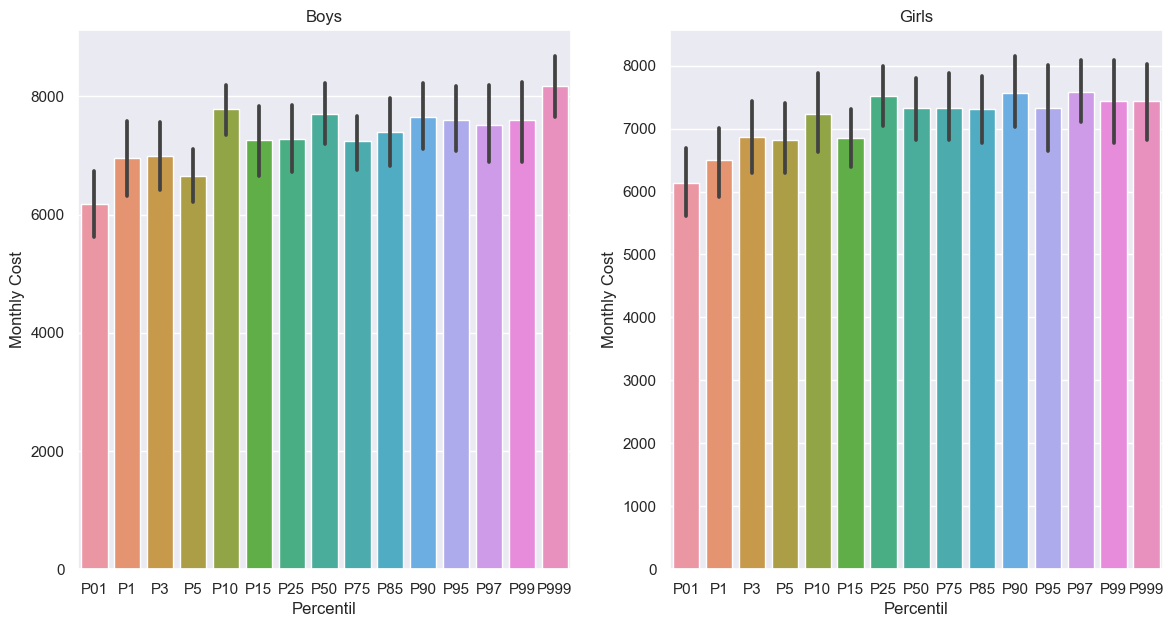

In [684]:
fig, ax =plt.subplots(1,2, figsize=(14, 7))
b = sns.barplot(data=nbp, ax=ax[0])
b.set_xlabel("Percentil")
b.set_ylabel("Monthly Cost")
# b.set_ylim(12000)
b.set_title("Boys")

g = sns.barplot(data=ngp, ax=ax[1])
g.set_xlabel("Percentil")
g.set_ylabel("Monthly Cost")
# g.set_ylim(12000)
g.set_title("Girls")

Text(0.5, 1.0, 'Girls')

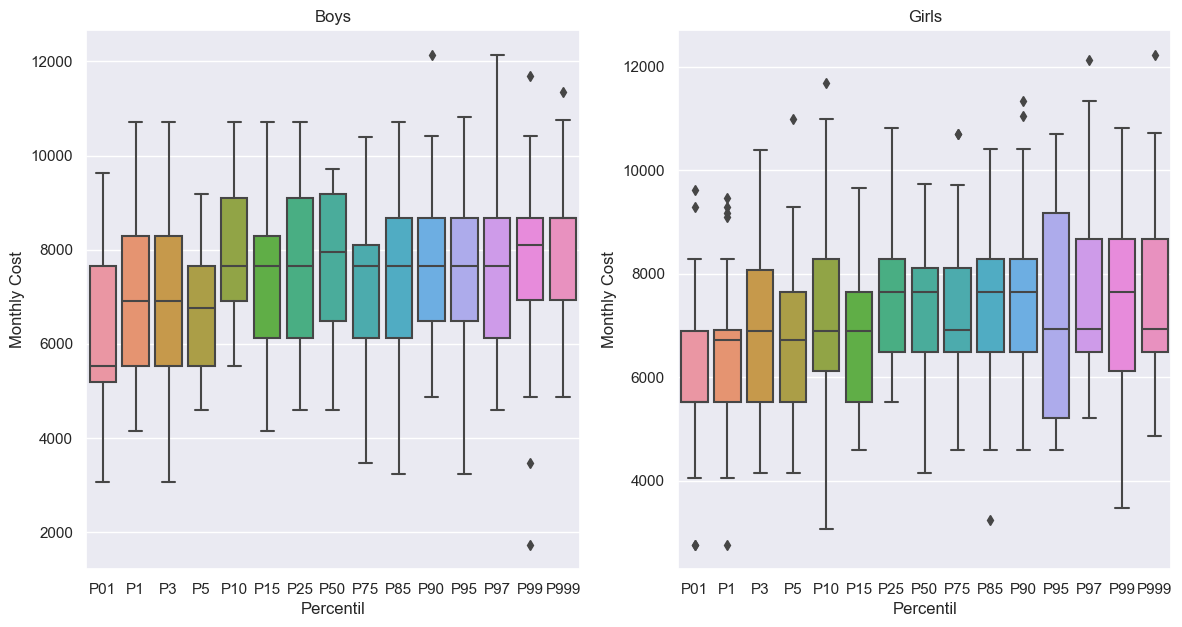

In [685]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

b = sns.boxplot(data=nbp, ax=ax[0])
b.set_xlabel("Percentil")
b.set_ylabel("Monthly Cost")
b.set_title("Boys")

g = sns.boxplot(data=ngp, ax=ax[1])
g.set_xlabel("Percentil")
g.set_ylabel("Monthly Cost")
g.set_title("Girls")

Text(0.5, 0.98, 'Girls')

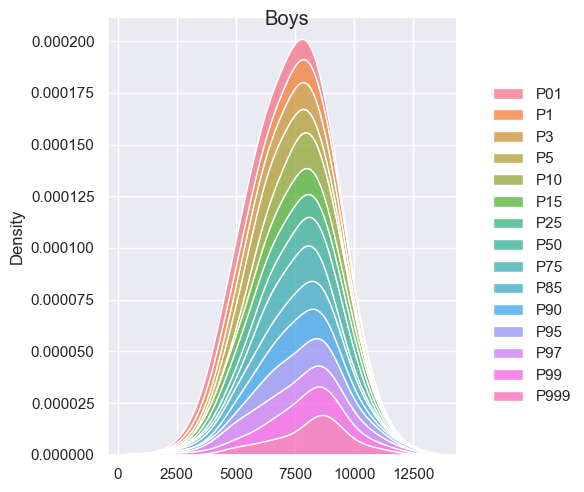

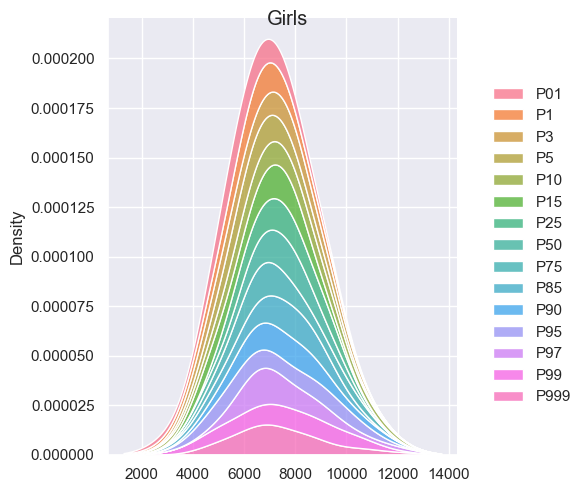

In [686]:
b = sns.displot(data=nbp,multiple="stack", kind="kde",)
b.fig.suptitle('Boys')

g = sns.displot(data=ngp,multiple="stack", kind="kde")
g.fig.suptitle('Girls')

Text(0.5, 0.98, 'Girls')

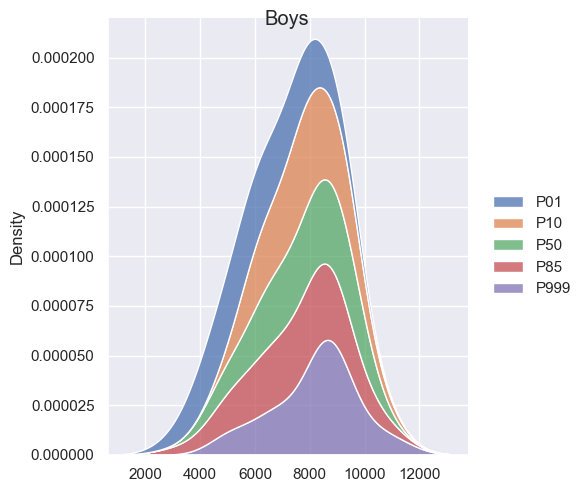

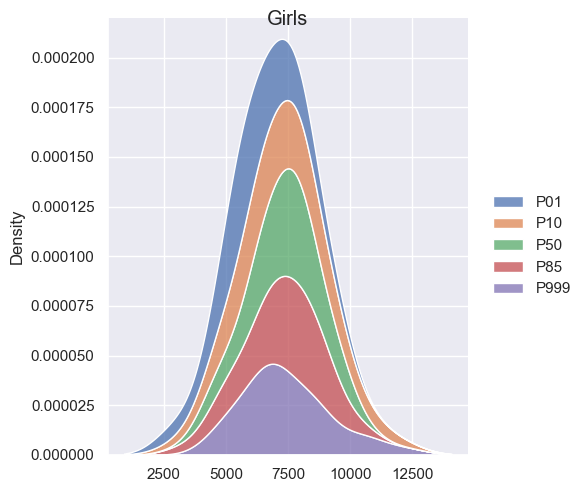

In [687]:
keys = [
 'P01',
 'P10',
 'P50',
 'P85',
 'P999'
]
_nbp = nbp[keys]
b = sns.displot(data=_nbp, multiple="stack", kind="kde")
b.fig.suptitle('Boys')

_ngp = ngp[keys]
g = sns.displot(data=_ngp, multiple="stack", kind="kde")
g.fig.suptitle('Girls')

#### Conclusiones preliminares:

- Observarmos que hay una tendencia levemente que indica mayor gasto en niños, se debe principalmente a que el niño tiene un peso mayor. 
- Observamos una distinción entre los percentiles para los siguientes percentiles `[ 'P01', 'P10', 'P85', 'P999' ]`  tanto para niños como niñas.
- La cantidad destinada al gasto de pañales no disminuye, por mas que el bebe tienda a utilizar menor cantidad.



#### Comparativa entre marcas

A continuación realizamos el mismo procesamiento pero en lugar de diferencias el presupuesto por genero, armamos el presupuesto mes a mes por marca.

In [688]:
def _filter_series(target_kg, custom_df, month):
    # Calculamos el costo mensual promedio para el percentil en base a *target_kg*
    # Utilizando un consumo mensual fijo de pañales
    _df = custom_df[custom_df['target_kg_min'] <= target_kg]
    _df[target_kg <= _df['target_kg_max']]
    return _df['unit_price'].mean() * _get_random_daily_usage(month) * 30

def _filter_d(target_kg, custom_df):
    return pd.Series([_filter_series(e, custom_df, i) for i, e in enumerate(target_kg)])


def _filter_brand(brand):
    df = prepare_df()
    return df[df['brand'] == brand]

def _prepare_percentils(brand):
    df = _filter_brand(brand)
    keys = [ 'P01', 'P1', 'P3', 'P5', 'P10', 'P15', 'P25', 'P50', 'P75', 'P85', 'P90', 'P95', 'P97', 'P99','P999']
    nbp = bp[keys]
    return nbp.apply(_filter_d, args=(df,))

h_df = _prepare_percentils('huggies')
p_df = _prepare_percentils('pampers')
b_df = _prepare_percentils('babysec')
e_df = _prepare_percentils('estrella')

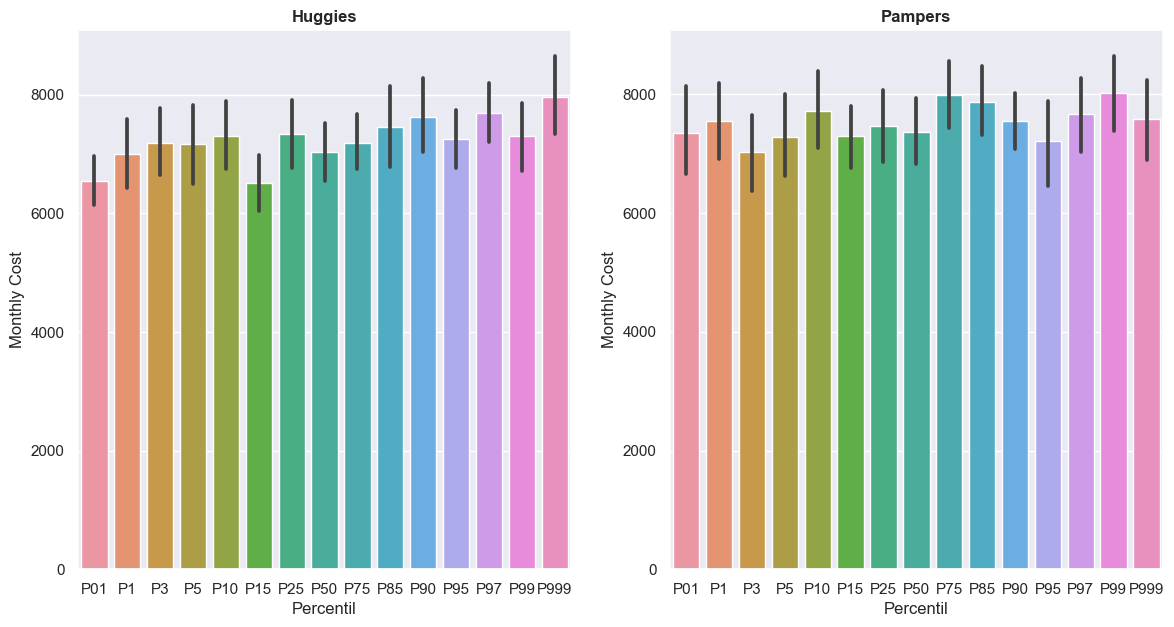

In [695]:
def _add_fig(df, name, ax):
    a = sns.barplot(data=df, ax=ax)
    a.set_title(name, fontweight='bold')
    a.set_ylabel("Monthly Cost")
    a.set_xlabel("Percentil")
    # a.set_ylim(11000)


fig, ax =plt.subplots(1,2, figsize=(14, 7))
_add_fig(h_df, "Huggies", ax=ax[0])
_add_fig(p_df, "Pampers", ax=ax[1])

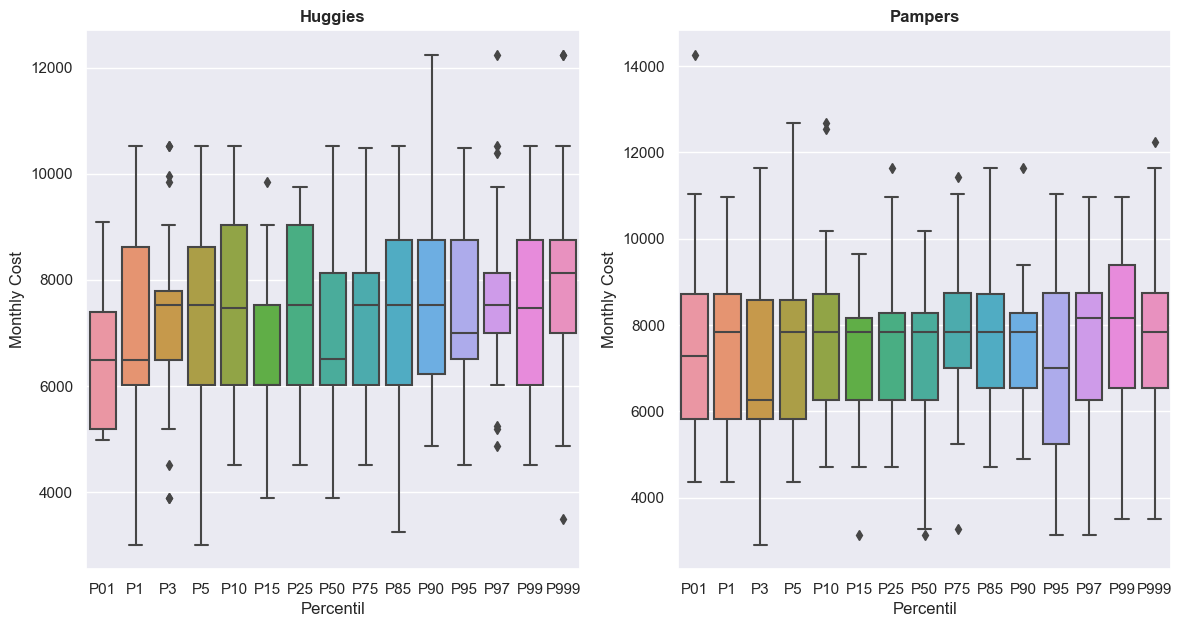

In [690]:
def _add_fig(df, name, ax):
    a = sns.boxplot(data=df, ax=ax)
    a.set_title(name, fontweight='bold')
    a.set_ylabel("Monthly Cost")
    a.set_xlabel("Percentil")


fig, ax =plt.subplots(1,2, figsize=(14, 7))
_add_fig(h_df, "Huggies", ax=ax[0])
_add_fig(p_df, "Pampers", ax=ax[1])

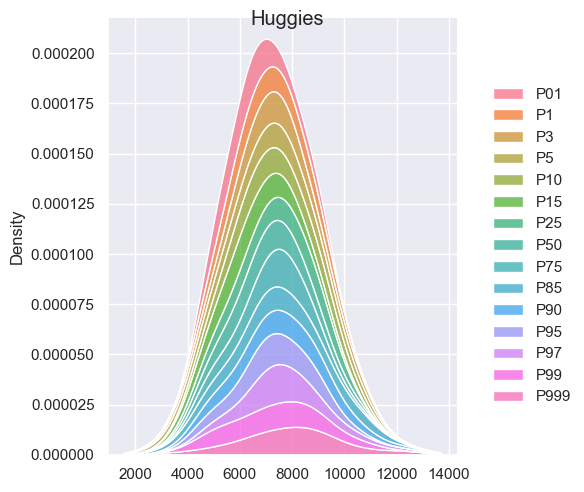

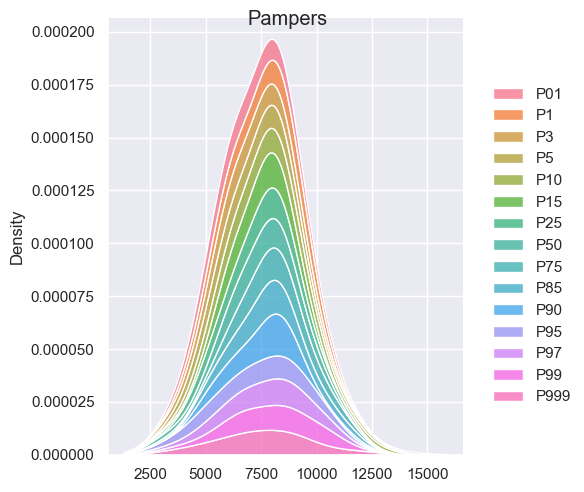

In [691]:
def _add_fig(df, name):
    b = sns.displot(data=df, multiple="stack", kind="kde")
    b.fig.suptitle(name)

_add_fig(h_df, "Huggies")
_add_fig(p_df, "Pampers")

#### Conclusiones preliminares:

- Pampers (49%) y Huggies (43.6%) son las marcas predominantes abarcando el ~92.6% de la muestra. Para el caso deBabysec y Estrella no podemos garantizar que sean numeros representativos porque no llegan al 10% de la muestra de items.
- Pampers es mas caro que Huggies para talles de pequeños (rn, p, m) que corresponden a los percentiles P01 a P15.
- 